In [2]:
import torch
import torch.nn as nn

import time
import numpy as np
import skimage.color as color
import matplotlib.pyplot as plt

from collections import OrderedDict
from torch.utils.data import DataLoader
from torchvision import transforms as tf, datasets as ds
from torchvision.utils import make_grid

In [3]:
data_root_color = 'C:/DataSets/Celeba/sample'
data_root_grayscale = 'C:/DataSets/Celeba/grayscale'
workers = 0
batch_size = 20
image_size = 256
nc = 3  # Number of output color channels.
nz = 1  # Number of input color channels (Latent vector).
ngf = 64    # Depth of feature map, carried through the generator(G).
ndf = 64    # Depth of feature map, carried through the discriminator(D).
number_epochs = 5
lr = 2e-4
beta = 5e-1
ngpu = 1
weight_decay = 1e-1

In [4]:
is_cuda_available = torch.cuda.is_available()
device = torch.device('cuda:0' if is_cuda_available and ngpu > 0 else 'cpu')
device

device(type='cuda', index=0)

In [6]:
image_transform = {
    "rgb": tf.Compose([
        tf.Resize(image_size),
        tf.CenterCrop(image_size),
        tf.ToTensor()
        # tf.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    "gray": tf.Compose([
        tf.Resize(image_size),
        tf.CenterCrop(image_size),
        tf.ToTensor()
        # tf.Normalize(mean=[0.5], std=[0.5])
    ])
}

In [5]:
# Grayscale image dataset load.
gray_set = ds.ImageFolder(root=data_root_grayscale, transform=image_transform["gray"])

In [6]:
gray_loader = DataLoader(gray_set, batch_size, shuffle=True, num_workers=workers, pin_memory=is_cuda_available)

Text(0.5, 1.0, 'GRAYSCALE IMAGE SAMPLE')

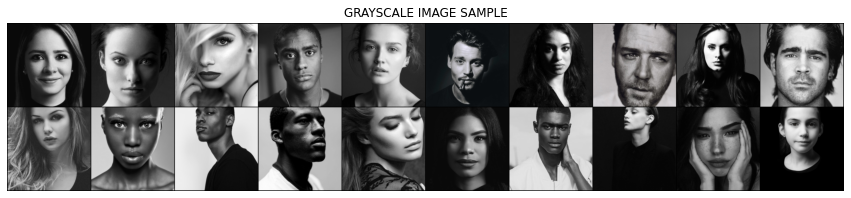

In [7]:
g_im = next(iter(gray_loader))

g_grid = make_grid(g_im[0], nrow=10, normalize=True)

plt.figure(figsize=(15, 14))
plt.imshow(np.transpose(g_grid, axes=(1, 2, 0)))
plt.axis('off')
plt.title('GRAYSCALE IMAGE SAMPLE')

In [8]:
color_set = ds.ImageFolder(root=data_root_color, transform=image_transform["rgb"])

In [9]:
color_loader = DataLoader(color_set, batch_size, shuffle=False, num_workers=workers, pin_memory=is_cuda_available)

Text(0.5, 1.0, 'COLOR IMAGE SAMPLE')

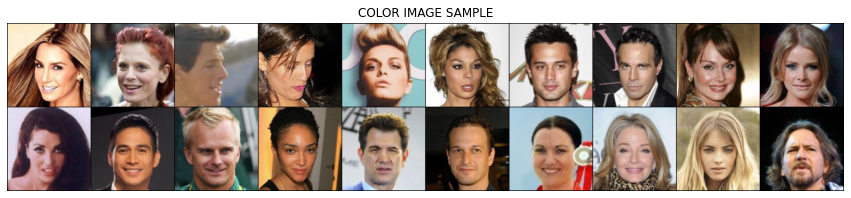

In [10]:
c_im = next(iter(color_loader))

c_grid = make_grid(c_im[0], nrow=10, normalize=True)

plt.figure(figsize=(15, 14))
plt.imshow(np.transpose(c_grid, axes=(1, 2, 0)))
plt.axis('off')
plt.title('COLOR IMAGE SAMPLE')

In [11]:
class RGB2LAB(object):

    def __call__(self, image):
        """
        :param image: PIL/NumPy image to be converted.
        :return: the LAB color channel image.
        """
        return color.rgb2lab(np.array(image))

class RGB2L(object):

    def __call__(self, image):
        """
        :param image: PIL/NumPy image to be converted.
        :return: the LAB color channel image.
        """
        return color.rgb2lab(np.array(image))[:, :, 0]


In [66]:
def lab2rgb(image, dim=None):
    """
    :param image is a single Lab image the shape of (X, y, 3)
    :param dim to define the color-channel dimension.
    """
    image = np.transpose(image, axes=(1, 2, 0))

    if dim is not None:
        z = np.zeros_like(image)
        if dim != 0:
            z[:, :, 0] = 80  # Increase the brightness to see other color channels(a & b).

        z[:, :, dim] = image[:, :, dim]
        return color.lab2rgb(z)
    else:
        return color.lab2rgb(image)

In [13]:
image_transform['lab'] = tf.Compose([
    tf.Resize(image_size),
    tf.CenterCrop(image_size),
    RGB2LAB(),
    tf.ToTensor()
    # tf.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_transform['l'] = tf.Compose([
    tf.Resize(image_size),
    tf.CenterCrop(image_size),
    RGB2L(),
    tf.ToTensor()
    # tf.Normalize(mean=[0.5], std=[0.5])
])

In [14]:
lab_set = ds.ImageFolder(root=data_root_color, transform=image_transform['lab'])
lab_loader = DataLoader(lab_set, batch_size, num_workers=workers, pin_memory=is_cuda_available)

In [15]:
l_set = ds.ImageFolder(root=data_root_color, transform=image_transform['l'])
l_loader = DataLoader(l_set, batch_size, num_workers=workers, pin_memory=is_cuda_available)

In [16]:
l_im = next(iter(l_loader))

## Colorizing Images with Supervised Learning

In [27]:
class ColorNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=3, n_layers=(32, 64, 32, 16, 4)):
        super(ColorNet, self).__init__()

        layers = []
        prev = in_channels

        for n in n_layers:
            layers.append(nn.Conv2d(in_channels=prev, out_channels=n, kernel_size=4, stride=2, padding=1)),
            layers.append(nn.BatchNorm2d(n)),
            layers.append(nn.ReLU())
            layers.append(nn.Upsample(scale_factor=2.))
            prev = n

        layers.append(nn.Conv2d(in_channels=prev, out_channels=out_channels, kernel_size=3, stride=1, padding=1))

        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)


colorNet = ColorNet().to(device).double()
colorNet

ColorNet(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode=nearest)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Upsample(scale_factor=2.0, mode=nearest)
    (8): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Upsample(scale_factor=2.0, mode=nearest)
    (12): Conv2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Upsample(scale_factor=2.0, mode=nearest)
    (16): Conv2d(16, 4, kernel_size=(4, 4),

In [28]:
count = 0
for param in colorNet.parameters():
    count += param.numel()

count

75819

In [72]:
torch.cuda.empty_cache()

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(colorNet.parameters(), lr=lr)

epochs = 5
losses = []

start = time.time()

for i in range(epochs):
    i += 1

    for batch, (X, y) in enumerate(zip(l_loader, lab_loader)):
        batch += 1

        optimizer.zero_grad()

        X = X[0].to(device)
        y = y[0].to(device)

        y_pred = colorNet(X)
        loss = criterion(y_pred, y)

        if batch == 1 or batch % 500 == 0:
            losses.append(loss)
            print(f'Epoch: {i}/{epochs}, Batch: {batch}/{len(l_loader)} => Loss: {loss}')


        loss.backward()
        optimizer.step()

duration = time.time() - start
print(f'Duration to execute: {duration / 60:0.4f} minutes')

Epoch: 1/1, Batch: 1/1500 => Loss: 64.35133909892942
Epoch: 1/1, Batch: 500/1500 => Loss: 51.51131784279653
Epoch: 1/1, Batch: 1000/1500 => Loss: 123.45833338619295
Epoch: 1/1, Batch: 1500/1500 => Loss: 79.97035375841554
Duration to execute: 23.2895 minutes


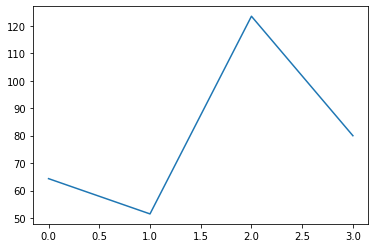

In [73]:
plt.plot(losses)

In [74]:
img_size = (image_size, image_size)

@torch.no_grad()
def view(image):

    colorNet.eval()

    image = colorNet(image.to(device))
    print(image.shape)

    image = lab2rgb(image.cpu().numpy().reshape(-1, *img_size))

    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256])


Text(0.5, 1.0, 'B CHANNEL SAMPLE')

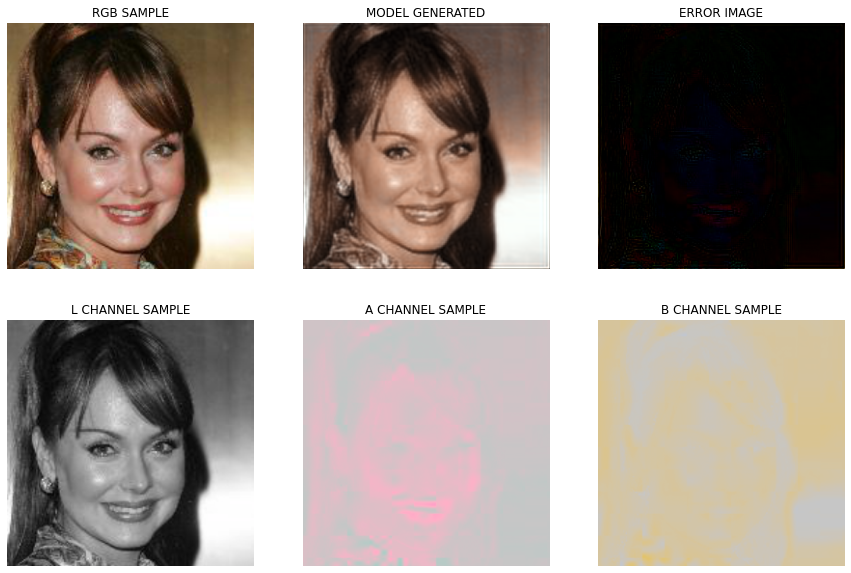

In [154]:
IMG_INDEX = 8

lab_im = next(iter(lab_loader))[0][IMG_INDEX]

plt.figure(figsize=(15, 10))

org = np.transpose(c_im[0][IMG_INDEX], axes=(1, 2, 0))

plt.subplot(231)
plt.imshow(org)
plt.axis('off')
plt.title('RGB SAMPLE')

image = l_im[0][IMG_INDEX]
image = view(image.view(-1, 1, *img_size).double())

plt.subplot(232)
plt.imshow(image)
plt.axis('off')
plt.title('MODEL GENERATED')

error = np.subtract(image, org) * -1

plt.subplot(233)
plt.imshow(error)
plt.axis('off')
plt.title('ERROR IMAGE')

plt.subplot(234)
plt.imshow(lab2rgb(lab_im, 0))
plt.axis('off')
plt.title('L CHANNEL SAMPLE')

plt.subplot(235)
plt.imshow(lab2rgb(lab_im, 1))
plt.axis('off')
plt.title('A CHANNEL SAMPLE')

plt.subplot(236)
plt.imshow(lab2rgb(lab_im, 2))
plt.axis('off')
plt.title('B CHANNEL SAMPLE')

## DCGAN to colorize grayscale images - Unsupervised Learning

In [4]:
class Generator(nn.Module):

    def __init__(self, in_channels=nz, out_channels=nc):
        super().__init__()

        # Convolutional Layers (ENCODE)
        self.encode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                # Input size -> (nz) x 256 x 256
                nn.Conv2d(in_channels=in_channels, out_channels=ngf, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(ngf),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv2', nn.Sequential(
                #State size -> (ngf) x 256 x 256
                nn.Conv2d(in_channels=ngf, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv3', nn.Sequential(
                # State size -> (ngf) x 128 x 128
                nn.Conv2d(in_channels=ngf, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 2),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv4', nn.Sequential(
                # State size -> (ngf * 2) x 64 x 64
                nn.Conv2d(in_channels=ngf * 2, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 4),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv5', nn.Sequential(
                # State size -> (ngf * 4) x 32 x 32
                nn.Conv2d(in_channels=ngf * 4, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv6', nn.Sequential(
                # State size -> (ngf * 8) x 16 x 16
                nn.Conv2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv7', nn.Sequential(
                # State size -> (ngf * 8) x 8 x 8
                nn.Conv2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv8', nn.Sequential(
                # State size -> (ngf * 8) x 4 x 4
                nn.Conv2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.LeakyReLU(negative_slope=0.2)
                # State size -> (ngf * 8) x 1 x 1
            ))
        ]))

        self.decode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                # Input size -> (ngf * 8) x 2 x 2
                nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.ReLU()
            )),
            ('conv2', nn.Sequential(
                # State size -> (ngf * 8) x 4 x 4
                nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.ReLU()
            )),
            ('conv3', nn.Sequential(
                # State size -> (ngf * 8) x 8 x 8
                nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.ReLU()
            )),
            ('conv4', nn.Sequential(
                # State size -> (ngf * 8) x 16 x 16
                nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 4),
                nn.ReLU()
            )),
            ('conv5', nn.Sequential(
                # State size -> (ngf * 4) x 32 x 32
                nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 2),
                nn.ReLU()
            )),
            ('conv6', nn.Sequential(
                # State size -> (ngf * 2) x 64 x 64
                nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf),
                nn.ReLU()
            )),
            ('conv7', nn.Sequential(
                # State size -> (ngf) x 128 x 128
                nn.ConvTranspose2d(in_channels=ngf, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf),
                nn.ReLU()
            )),
            ('parametric', nn.Sequential(
                # State size -> (ngf) x 256 x 256
                nn.ConvTranspose2d(in_channels=ngf, out_channels=out_channels, kernel_size=1, stride=1, bias=False),
                nn.Tanh()
                # State size -> (ngf) x 256 x 256
            ))
        ]))

        self.encode_children = dict(self.encode.named_children())
        self.decode_children = dict(self.decode.named_children())

    def forward(self, x):

        x = self.encode(x)
        x = self.decode(x)

        return x


netG = Generator().to(device)
netG

Generator(
  (encode): Sequential(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [7]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                # Input size -> (nz) x 256 x 256
                nn.Conv2d(in_channels=nc, out_channels=ngf, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(ngf),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv2', nn.Sequential(
                #State size -> (ngf) x 256 x 256
                nn.Conv2d(in_channels=ngf, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv3', nn.Sequential(
                # State size -> (ngf) x 128 x 128
                nn.Conv2d(in_channels=ngf, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 2),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv4', nn.Sequential(
                # State size -> (ngf * 2) x 64 x 64
                nn.Conv2d(in_channels=ngf * 2, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 4),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv5', nn.Sequential(
                # State size -> (ngf * 4) x 32 x 32
                nn.Conv2d(in_channels=ngf * 4, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv6', nn.Sequential(
                # State size -> (ngf * 8) x 16 x 16
                nn.Conv2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv7', nn.Sequential(
                # State size -> (ngf * 8) x 8 x 8
                nn.Conv2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv8', nn.Sequential(
                # State size -> (ngf * 8) x 4 x 4
                nn.Conv2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.LeakyReLU(negative_slope=0.2)
                # State size -> (ngf * 8) x 1 x 1
            )),
            ('sigmoid', nn.Sequential(
                # State size -> (ngf * 8) x 4 x 4
                nn.Conv2d(in_channels=ngf * 8, out_channels=nz, kernel_size=4, stride=2, padding=1, bias=False),
                nn.Sigmoid()
                # State size -> (nz) x 1 x 1
            ))
        ]))

    def forward(self, x):
        return self.main(x)


netD = Discriminator().to(device)
netD

Discriminator(
  (main): Sequential(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True